<center> <h1> Agent-Based Model of Panic</h1> </center>

### Import Packages

In [2]:
import random
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import statistics
import math
import numpy as np
import seaborn as sns
import pyabc
from sklearn.metrics import mean_squared_error as mse

### Figure Settings

In [3]:
plt.rc('figure', figsize=(12, 8))
plt.rcParams['font.size'] = '24'
sns.set_style("ticks", {'font.family': 'Times New Roman'})
sns.set_palette("Paired")

### Model Class

In [4]:
class Model():

    def __init__(self, num_of_agents, num_iterations, agent_groups): 
        
        self.num_of_agents = num_of_agents
        self.num_iterations = num_iterations
        self.agent_groups = agent_groups

        self.time = 0 #model time
        
        #creating lists
        self.num_infected_per_iteration = []
        
        #create the agents
        self.agents = []
        
        for key in self.agent_groups.keys():
#             print(key)
            for i in range(round(self.agent_groups[key][2] * num_of_agents)):
                agent = Agent(self, key, key[0], key[1])
                agent.beta = self.agent_groups[key][0]
                agent.alpha = self.agent_groups[key][1]
#                 print(agent)
                self.agents.append(agent)
        
        self.infected_per_group = {}
        
        for g in self.agent_groups:
            self.infected_per_group[g] = []
        

    def get_num_infected(self):
        return len(([a for a in self.agents if a.state==1])) 
    
    def run(self):
        for t in range(self.num_iterations):
            for agent in self.agents:
                if t >=1:
                    agent.step()
           
            for g in self.agent_groups:
                group_agents = [a for a in self.agents if a.group == g]
                num_infected = sum([a.state for a in group_agents])
                self.infected_per_group[g].append(num_infected)
        
    
            self.num_infected_per_iteration.append(self.get_num_infected())
        
        
            self.data = pd.DataFrame(self.infected_per_group)
            self.data.reset_index(inplace = True, drop = False)
            
            self.dataset = pd.DataFrame(self.num_infected_per_iteration)
        
            
            self.result = pd.merge(self.data, self.dataset, left_index=True, right_index=True)
            self.result.rename(columns={self.result.columns[-1]: "num_infected" }, inplace = True)
        
    
            self.time += 1


### Agent Class

In [5]:
class Agent():
    
    def __init__(self, Model, group, beta, alpha, gamma= 0.1):
        
        #intialising parameters
        self.state = 0
        
        self.alpha = alpha
        self.gamma = gamma
        self.beta = beta 
        
        self.model = Model
        
        self.group = group
        
        self.likelihood = 0

    def step(self):
        if self.state == 0:
            self.become_panicked()
            
        else:
            self.recover()
        
    def become_panicked(self):
        
        Agent_i = random.choice(self.model.agents)
        
        if Agent_i.state == 1:
            self.likelihood = self.alpha + self.beta
        else:
            self.likelihood = self.alpha
        
        r_v = random.random()
        if r_v < self.likelihood: 
            self.state = 1

       
    def recover(self): 
        r_v = random.random()
        if self.state == 1:
            if r_v < self.gamma:
                self.state = 0

### Run Model

In [ ]:
#Run model
agent_groups = {'Group1':[0.2, 0.01, 1.0]}
model = Model(num_of_agents=1000, num_iterations=1000, agent_groups=agent_groups)
model.run()

## pyABC

pyABC package can be found here: https://pyabc.readthedocs.io/en/latest/

### Model Function

In [6]:
def my_model(input_params_dict):
    """
    Creating the model function that feeds the ABC package the case study ABM.
    This function includes the creation of a dictionary, 
    which contains the parameter of interest: 'number of panicked' agents
    """
    #Creating a dictionary of unknown parameters
    beta_1 = input_params_dict["Beta"]
    alpha = input_params_dict["Alpha"]

    #initialising ABM with number of agent groups
    agent_groups = {'Group1': [beta_1, alpha, 1.0]}

    #intialising ABM with number of agents, iterations and agent groups
    ABM = Model(num_of_agents=1000, num_iterations=1000, agent_groups=agent_groups)

    #run the ABM
    ABM.run()
    
    #sampling from number of infected for cdf
    s = ABM.dataset[800:]
    sample_2 = s.reset_index(drop=False, inplace=False)
    sample_2.rename(columns={sample_2.columns[1]: "num_infected" }, inplace = True)
    sample = sample_2['num_infected']
    
    #getting mean number of infected over whole dataset
    num_inf = ABM.dataset.reset_index(drop=False, inplace=False)
    num_inf.rename(columns={num_inf.columns[1]: "num_infected" }, inplace = True)
    num = num_inf["num_infected"]
    mean_num = num.mean()
    
    #calling function to create cdf
    result = distribution(sample, ABM)
    
    return {"cumul_dist": result, "mean_inf": mean_num }

### Distance and Distribution Functions

In [7]:
def distribution(sample, ABM):
    x = np.arange(ABM.num_of_agents +2) -0.5
    hist, bin_edges = np.histogram(sample, x)
    cdf = np.cumsum(hist)/len(sample)
    #plt.plot(cdf, label="CDF")
    return (cdf)

In [8]:
def distance(model_result_dict, observations_dict):
    """
    The function that calculates the absolute difference
    between my ABM results and the ABC observations.
    """
    model_result = model_result_dict['cumul_dist']
    model_result = np.array(model_result)
    
    observation = observations_dict['observation'] 
    observation = np.array(observation)

    RMSE = math.sqrt(mse(model_result, observation))
    return (RMSE)

### Assigning pyABC true parameters and observation

In [9]:
#Assigning pyABC true parameters for reference
Group1_Beta_PARAM= 0.2
Alpha_PARAM = 0.01

In [10]:
truth_model = my_model({"Beta": Group1_Beta_PARAM, "Alpha": Alpha_PARAM})
obs = truth_model['cumul_dist']

### Priors and Parameter Lowerbounds

In [13]:
#Here, I'm assuming that the 'Number of panicked' parameter is normally distributed

Group1_Beta_param_rv = pyabc.RV("uniform", 0.0, 1.0)
Alpha_param_rv =pyabc.RV("uniform", 0, 0.1)

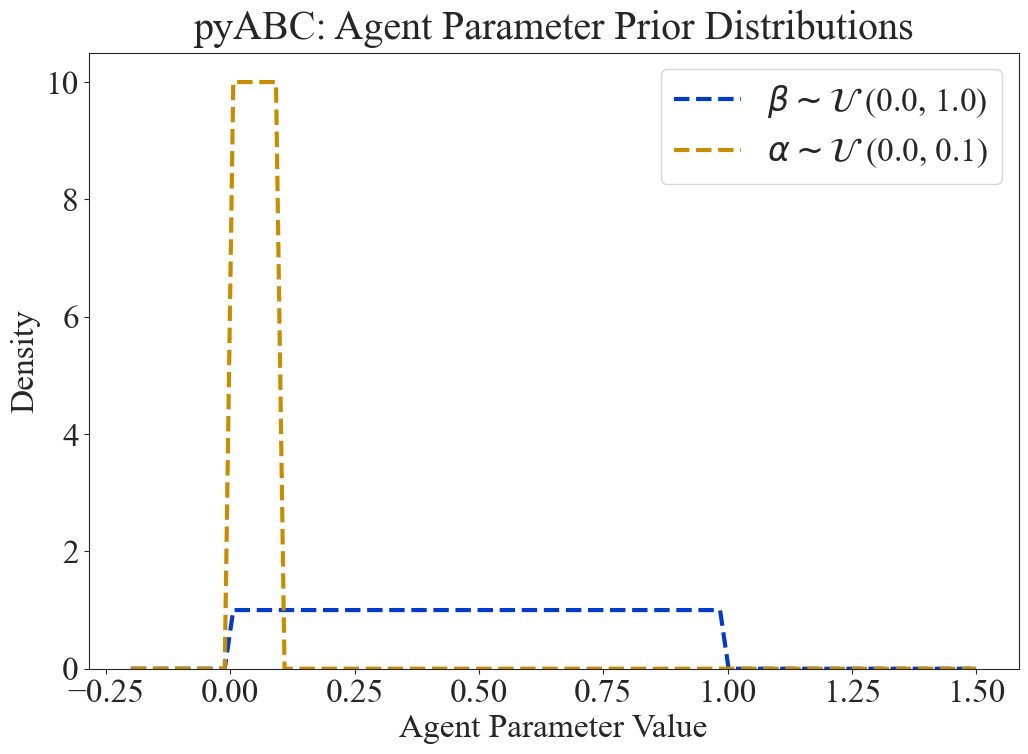

In [14]:
x= np.linspace(-0.2, 1.5, 100)

lines = plt.plot(x, pyabc.Distribution(param=Group1_Beta_param_rv).pdf({"param": x}), '--', label = r'$\beta$$\sim$$\mathcal{U}$ (0.0, 1.0)', lw = 3, color='#013AC6')
lines = plt.plot(x, pyabc.Distribution(param=Alpha_param_rv).pdf({"param": x}), '--', label = r'$\alpha$$\sim$$\mathcal{U}$ (0.0, 0.1)', lw = 3, color='#C68D01') 

plt.title('pyABC: Agent Parameter Prior Distributions', pad=10)
plt.ylabel('Density')
plt.xlabel('Agent Parameter Value')
plt.ylim([0, None])
plt.legend()
#plt.savefig("pyABC_Priors_Homo", bbox_inches="tight")

In [15]:
#Lower bound is 0, for the returned value
priors = pyabc.Distribution(Beta=pyabc.LowerBoundDecorator(Group1_Beta_param_rv, 0.0),
                            Alpha=pyabc.LowerBoundDecorator(Alpha_param_rv, 0.0))

### Run pyABC Algorithm

In [ ]:
'''
Running the package
'''

abc = pyabc.ABCSMC(
    models=my_model,  
    parameter_priors=priors, 
    distance_function=distance,
    population_size=1000,
    sampler=pyabc.sampler.MulticoreEvalParallelSampler())

db_path = ("sqlite:///" + "homo_database.db") 

run_id = abc.new(db_path, {'observation': obs})
print(f"Running new ABC with id {run_id}.... ", flush=True)


abc_history = abc.run(max_nr_populations=12)

### Load Previous Runs from pyABC Database

In [16]:
abc_continued = pyabc.ABCSMC(models=my_model,  
    parameter_priors=priors, 
    distance_function=distance,
    sampler=pyabc.sampler.MulticoreEvalParallelSampler())

ABC.Sampler INFO: Parallelize sampling on 4 processes.


In [17]:
db_path = ("sqlite:///" + "homo_database.db")

In [18]:
abc_continued.load(db_path, 7)

### Posterior Modes

In [21]:
for i, param in enumerate(priors.keys()):
    for t in range(abc_continued.history.max_t+1):
        df, w = abc_continued.history.get_distribution(m=0, t=t)
        X, Y = pyabc.visualization.kde.kde_1d(df, w, x = param)
        mode = X[np.where(Y == max(Y))]
        print(param, mode)

Beta [0.27874183]
Beta [0.17799358]
Beta [0.13861517]
Beta [0.07797279]
Beta [0.09069103]
Beta [0.06979561]
Beta [0.09823501]
Beta [0.13899384]
Beta [0.18239518]
Beta [0.18306601]
Beta [0.17749642]
Beta [0.18851214]
Alpha [0.07139129]
Alpha [0.0490366]
Alpha [0.07540661]
Alpha [0.08566693]
Alpha [0.08360147]
Alpha [0.08573803]
Alpha [0.06521725]
Alpha [0.04069004]
Alpha [0.02032493]
Alpha [0.02034568]
Alpha [0.02016144]
Alpha [0.01595468]


### Posterior Distributions Visualations

In [107]:
_df, _w = abc_continued.history.get_distribution(m=0, t=abc_continued.max_t)
# Merge dataframe and weights and sort by weight (highest weight at the top)
_df['weight'] = _w
posterior_df = _df.sort_values('weight', ascending=False).reset_index()

In [25]:
observation = {'Beta': [0.2],
               'Alpha':[0.01]}

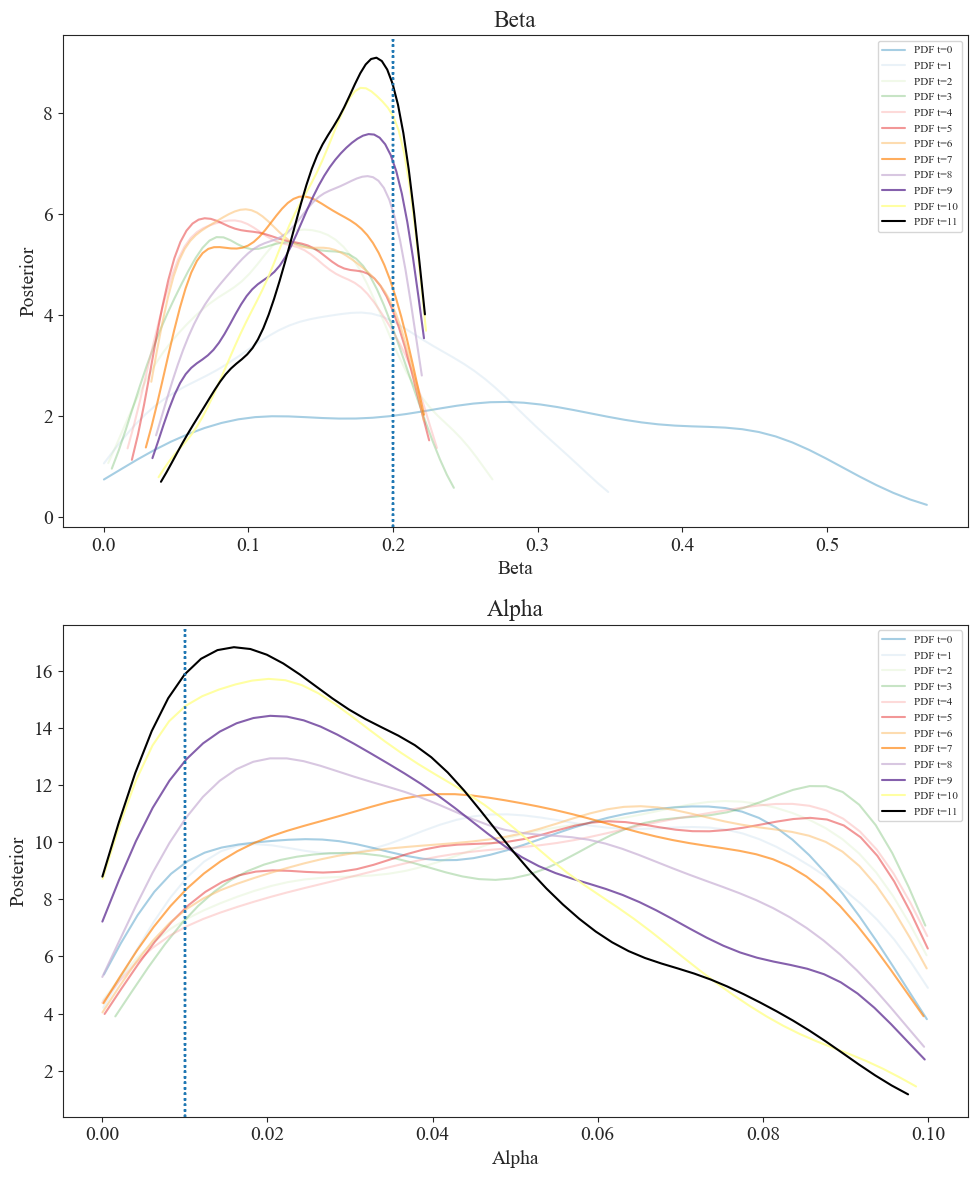

In [27]:
fig, axes = plt.subplots(2,int(len(priors)/2), figsize=(10,12), dpi=100)

for i, param in enumerate(priors.keys()):
    ax = axes.flat[i]
    for t in range(abc_continued.history.max_t + 1):
        df, w = abc_continued.history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax,
            label=f"PDF t={t}",  refval=observation,                            
            alpha=1.0 if t==0 else float(t)/abc_continued.history.max_t, # Make earlier populations transparent
            color= "black" if t==abc_continued.history.max_t else None # Make the last one black
        ) 
        ax.set_title(f"{param}: {posterior_df.loc[0,param]}")
        ax.set_title(f"{param}")
    ax.legend(fontsize="xx-small")
fig.tight_layout()
#fig.savefig('pyabc_posterior_homo.png', bbox_inches="tight")

#ax.axvline(x=posterior_df.loc[0,param], color="grey", linestyle="dashed")  

<Axes: title={'center': 'Effective sample size'}, xlabel='Population index', ylabel='ESS'>

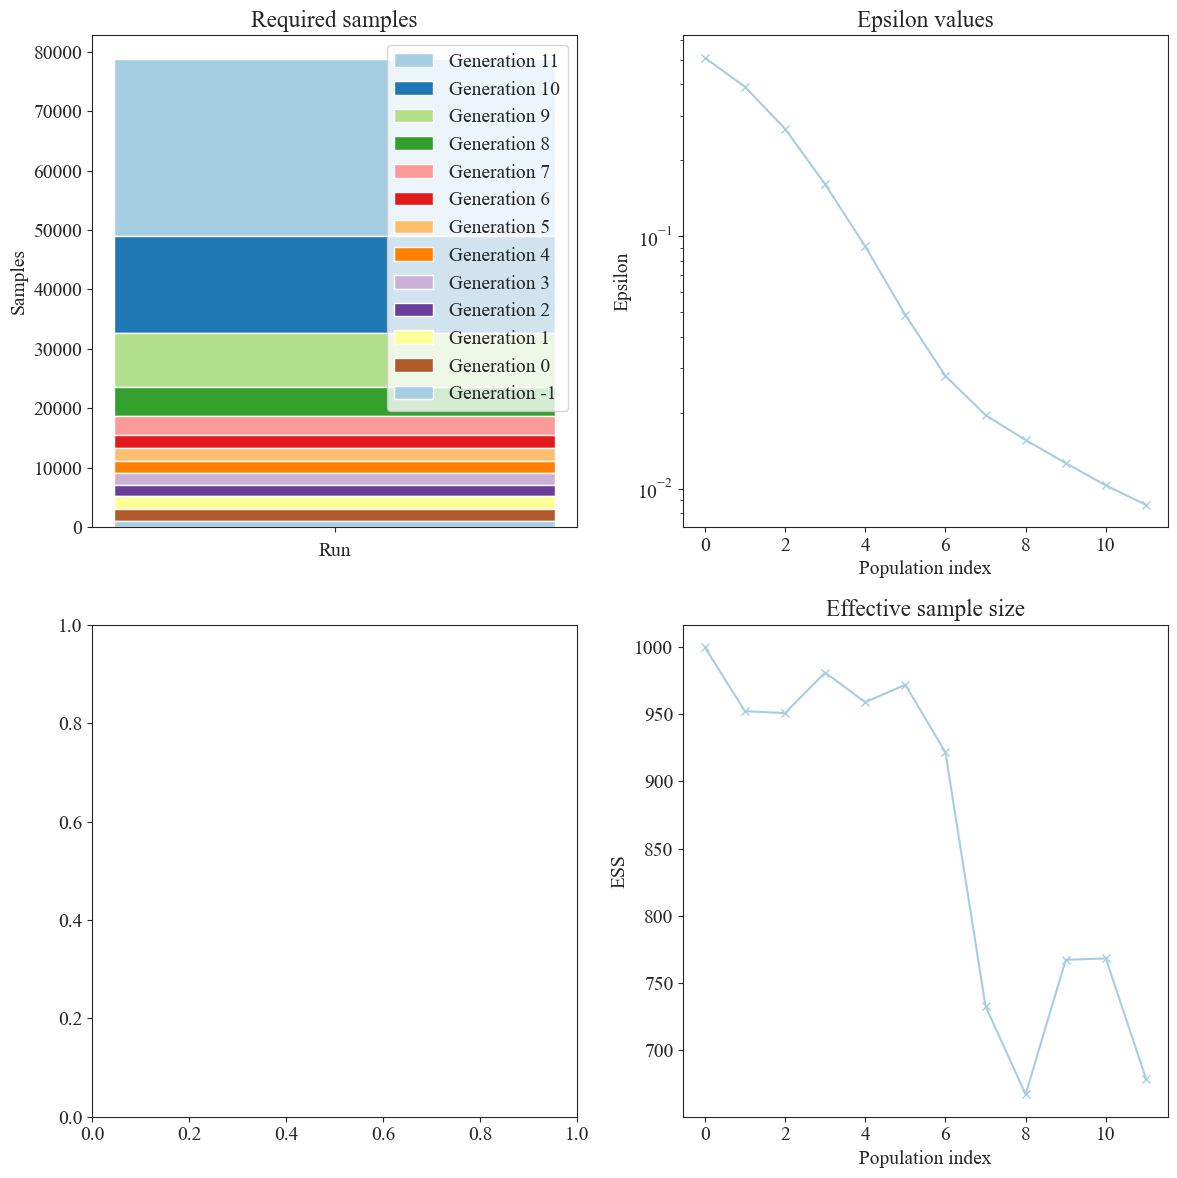

In [108]:
fig, arr_ax = plt.subplots(2, 2, figsize=(12, 12))

pyabc.visualization.plot_sample_numbers(abc_continued.history, ax=arr_ax[0][0])
pyabc.visualization.plot_epsilons(abc_continued.history, ax=arr_ax[0][1])
pyabc.visualization.plot_effective_sample_sizes(abc_continued.history, ax=arr_ax[1][1])

#fig.savefig('pyabc_output_homo.png', bbox_inches="tight")

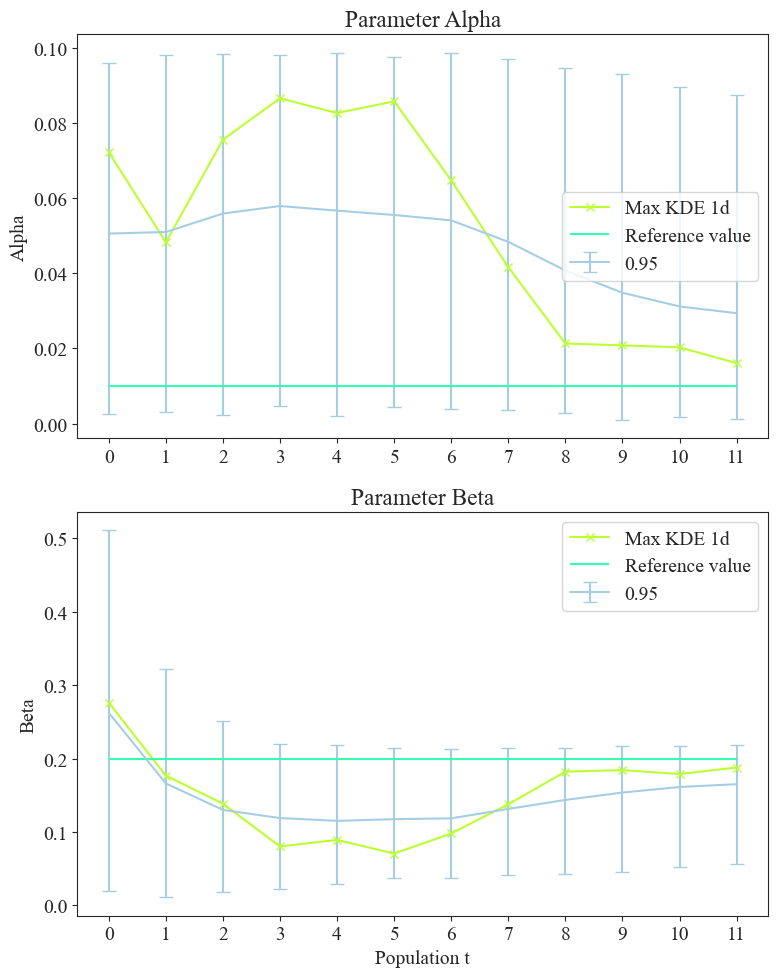

In [72]:
pyabc.visualization.plot_credible_intervals(
    abc_continued.history,
    show_kde_max_1d=True, 
    size=(8,10),
    color_kde_max_1d = '#BBFF33',
    refval_color = '#33FFB0',
    refval=observation)
#plt.savefig('pyabc_output_homo_ci.png', bbox_inches="tight", dpi=128)

### Identifiability Analysis

In [37]:
abc_output = abc_continued.history.get_population_extended()

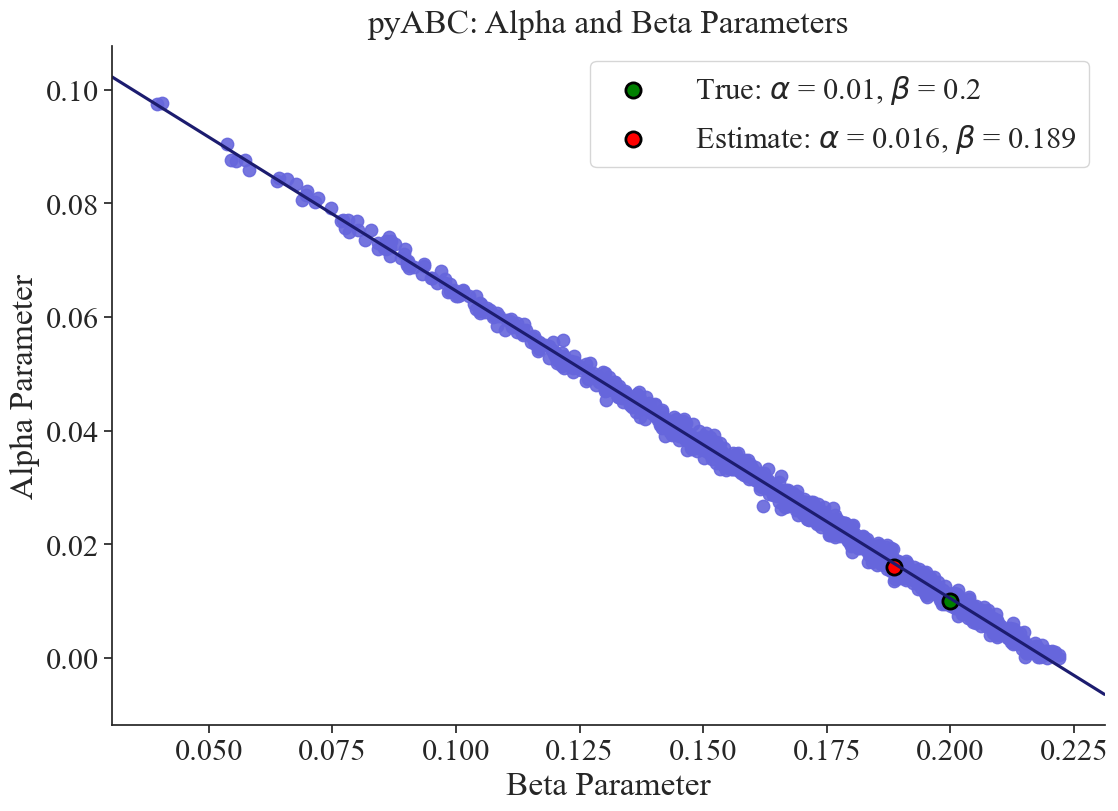

In [41]:
sns.set(rc={'figure.figsize':(20,15)}, font_scale=2) 
sns.set_style("ticks", {'font.family': 'Times New Roman'})
sns.set_palette("Paired")

g = sns.lmplot(y="par_Alpha", x="par_Beta", data=abc_output,
           scatter_kws={"s": 80, "alpha": 0.9, "color":'#6666DC'},   
           line_kws={"color":'#1C1C6F'}, height=8.27, aspect=11.7/8.27, ci=None,
          truncate=False)

plt.scatter(0.2, 0.01,  edgecolor="black", facecolor="green", 
            label=r' True: $\alpha$ = {:.2f}, $\beta$ = {:.1f}'.format(Alpha_PARAM, Group1_Beta_PARAM),
            linewidth=2, s=120)
plt.scatter(0.18851214, 0.01595468,  edgecolor="black", facecolor="red", 
            label=r' Estimate: $\alpha$ = {:.3f}, $\beta$ = {:.3f}'.format(0.01595468, 0.18851214),
            linewidth=2, s=120)

#g.set(ylim=(0, 0.1)) #xlim=(0, 0.3),
plt.legend()
plt.title('pyABC: Alpha and Beta Parameters', pad=10)
plt.ylabel("Alpha Parameter")
plt.xlabel("Beta Parameter")
#plt.savefig('pyabc:alpha_beta_param.png', bbox_inches='tight', dpi=128)
#r'$\Beta_One$ true = {:.1f}, $\Beta_Two$ true = {:.1f}'.format(Group1_Beta_PARAM, Group2_Beta_PARAM),

/var/folders/_j/4c2b89316wd99t00g9sfp7p40000gn/T/ipykernel_17742/3611352834.py:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = ax.figure.colorbar(ax.collections[0].set_clim(0,2), cmap="mako")


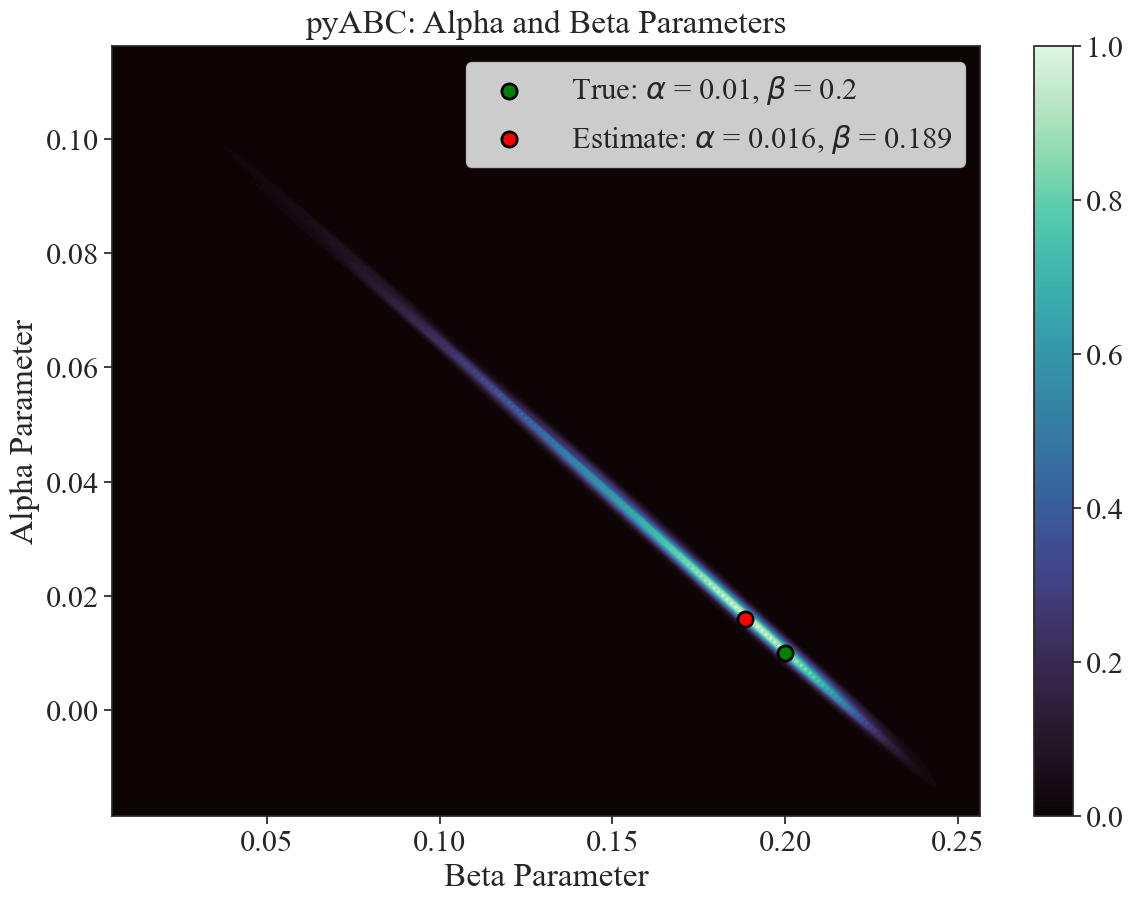

In [112]:
sns.set(rc={'figure.figsize':(14,10)}, font_scale=2) 
sns.set_style("ticks", {'font.family': 'Times New Roman'})
sns.set_palette("Paired")

ax = sns.kdeplot(
    data=posterior_df, x="Beta", y="Alpha",
    fill=True, 
    thresh=0, 
    levels=100, 
    cmap="mako",
    cbar = False)

plt.scatter(0.2, 0.01,  edgecolor="black", facecolor="green", 
            label=r' True: $\alpha$ = {:.2f}, $\beta$ = {:.1f}'.format(Alpha_PARAM, Group1_Beta_PARAM),
            linewidth=2, s=120)
plt.scatter(0.18851214, 0.01595468,  edgecolor="black", facecolor="red", 
            label=r' Estimate: $\alpha$ = {:.3f}, $\beta$ = {:.3f}'.format(0.01595468, 0.18851214),
            linewidth=2, s=120)

ax.set_title(f"pyABC: Alpha and Beta Parameters", pad=10)
plt.xlabel("Beta Parameter")
plt.ylabel("Alpha Parameter")
plt.legend()

cbar = ax.figure.colorbar(ax.collections[0].set_clim(0,2), cmap="mako")

#plt.savefig('homo:heatmap', bbox_inches='tight', dpi=128)

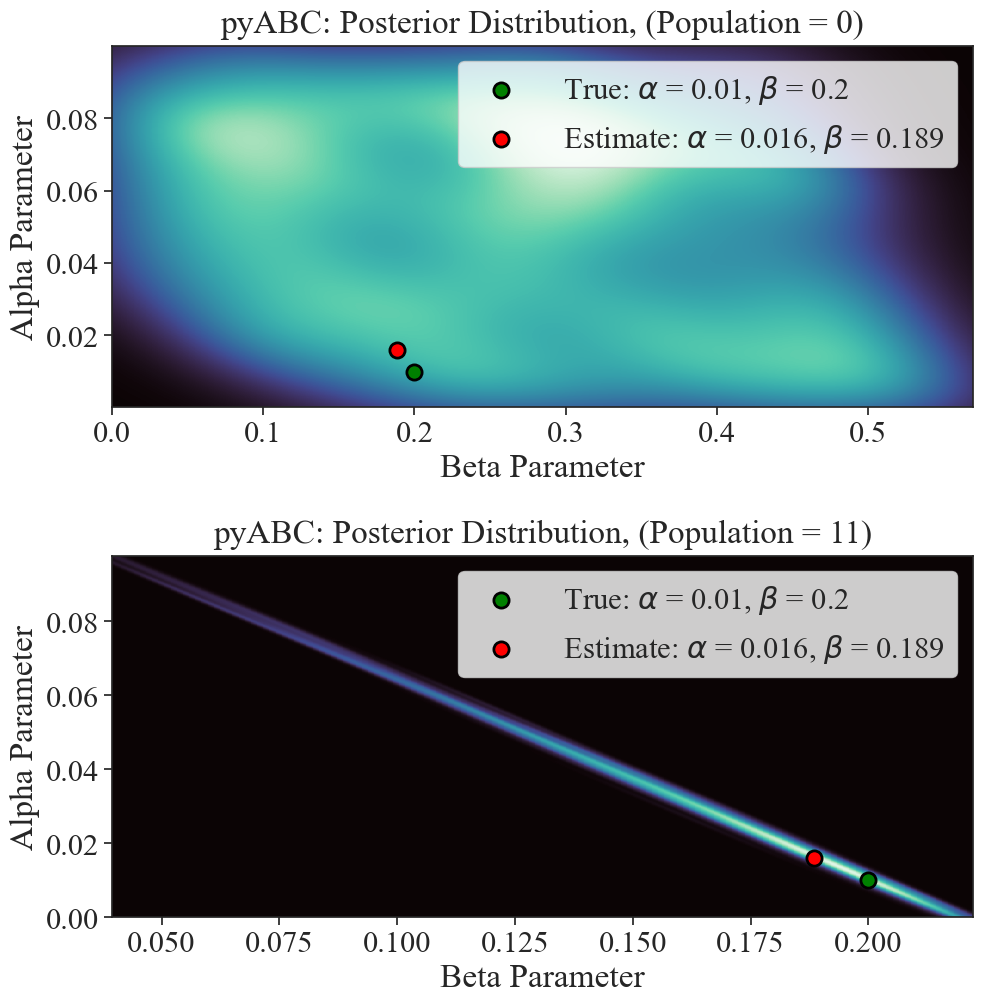

In [43]:
fig = plt.figure(figsize=(100, 20))

for t in [0, abc_continued.history.max_t]: 
    ax = fig.add_subplot(4, int(np.ceil(abc_continued.history.max_t)), t+1 )
    ax = pyabc.visualization.plot_kde_2d(
        *abc_continued.history.get_distribution(m=0, t=t),
        "Beta",
        "Alpha",
        numx=1000,
        numy=1000,
        cmap="mako",
        colorbar =False,
        ax=ax)
    ax.set_title(f"pyABC: Posterior Distribution, (Population = {t})", pad=10)
    
    plt.scatter(0.2, 0.01,  edgecolor="black", facecolor="green", 
            label=r' True: $\alpha$ = {:.2f}, $\beta$ = {:.1f}'.format(Alpha_PARAM, Group1_Beta_PARAM),
            linewidth=2, s=120)
    plt.scatter(0.18851214, 0.01595468,  edgecolor="black", facecolor="red", 
            label=r' Estimate: $\alpha$ = {:.3f}, $\beta$ = {:.3f}'.format(0.01595468, 0.18851214),
            linewidth=2, s=120)
    plt.xlabel("Beta Parameter")
    plt.ylabel("Alpha Parameter")
    plt.legend()

fig.tight_layout()
#plt.savefig('homo:heatmap-pop', bbox_inches='tight', dpi=128)